# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Load-Embedding" data-toc-modified-id="Load-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Embedding</a></div><div class="lev1 toc-item"><a href="#Load-sent2vec" data-toc-modified-id="Load-sent2vec-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load sent2vec</a></div><div class="lev1 toc-item"><a href="#K-means-clustering" data-toc-modified-id="K-means-clustering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>K-means clustering</a></div><div class="lev2 toc-item"><a href="#Test" data-toc-modified-id="Test-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Test</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Train</a></div><div class="lev1 toc-item"><a href="#Visualizing-Document-Clusters" data-toc-modified-id="Visualizing-Document-Clusters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualizing Document Clusters</a></div><div class="lev2 toc-item"><a href="#Multidimensional-Scaling" data-toc-modified-id="Multidimensional-Scaling-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Multidimensional Scaling</a></div><div class="lev1 toc-item"><a href="#Result" data-toc-modified-id="Result-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Result</a></div><div class="lev1 toc-item"><a href="#Show" data-toc-modified-id="Show-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Show</a></div>

# Load Data

In [89]:
import json
import os

In [90]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [94]:
sentence = load_data('/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/data/version_2/raw_data.json', 'abstract')

# Word Segmentation

In [4]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')
stopWords = ['“', '”', '（', '）', '(', ')', '《', '》', '.', '%']

In [6]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [7]:
sentWords = [del_stop(newcut(s)) for s in sentence]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/kz/hqjl_dfx3g3_2vxylxlj1s940000gn/T/jieba.cache
Loading model cost 0.975 seconds.
Prefix dict has been built succesfully.


# Tokenize Text

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [10]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	21273
Distribution of sentence lengths (number of words):
Min: 6   Max: 503   Mean: 81.775   Med: 77.000
Found 58192 unique tokens.


In [11]:
MAX_LEN = 160 # Approximately twice the median length of sentences

In [14]:
def convert_seq(ws):
    """
    Pad words sequene to MAX_LEN 
    """
    sentText = [' '.join(i) for i in ws]
    sentSeq = tokenizer.texts_to_sequences(sentText)
    sentData = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
    return sentData

In [15]:
x = convert_seq(sentWords)

# Load Embedding

In [17]:
import h5py
import os

In [18]:
DATA_DIR = '/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/sent2vec/version_2'

In [21]:
with h5py.File(os.path.join(DATA_DIR, 'allData.h5'), 'r') as fh:
    xTrain = fh['xTrain'][:]
    xTest = fh['xTest'][:]
    embedding = fh['embedding'][:]

# Load sent2vec

In [22]:
MAX_LEN = 160
VOCAB_SIZE = embedding.shape[0]
EMBEDDING_SIZE = 256
LATENT_SIZE = 512
NUM_EPOCHS = 64
BATCH_SIZE = 64
NUM_TRAIN_STEPS = len(xTrain) // BATCH_SIZE
NUM_TEST_STEPS = len(xTest) // BATCH_SIZE

In [26]:
from keras.layers import Input, Masking, Bidirectional, LSTM, RepeatVector
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
K.clear_session()
inputs = Input(shape=(MAX_LEN, EMBEDDING_SIZE), name='INPUT') 
mask = Masking(mask_value=0., name='MASKING')(inputs)
encoded = Bidirectional(LSTM(LATENT_SIZE, return_sequences=False, implementation=0), merge_mode='sum', name='ENCODER_BiLSTM')(mask)
decoded = RepeatVector(MAX_LEN, name="REPEATER")(encoded)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, implementation=0), merge_mode='sum', name='DECODER_BiLSTM')(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(loss='mse', optimizer='sgd')

In [29]:
filename = os.path.join(DATA_DIR, 'cp_logs/weights.034-0.002746.hdf5')
autoencoder.load_weights(filename, by_name=True)

In [30]:
# extract encoder part from autoencoder
encoder = Model(autoencoder.input, autoencoder.get_layer("ENCODER_BiLSTM").output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 160, 256)          0         
_________________________________________________________________
MASKING (Masking)            (None, 160, 256)          0         
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
Total params: 3,149,824
Trainable params: 3,149,824
Non-trainable params: 0
_________________________________________________________________


In [32]:
sent2vec = encoder.predict(embedding[x], batch_size=BATCH_SIZE, verbose=1)

21273/21273 [==============================] - 841s   


# K-means clustering

In [34]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [44]:
def train(X, num_clusters=10):
    """
    K-means training
    """
    km = KMeans(n_clusters=num_clusters, 
                init='k-means++', 
                max_iter=3000, 
                n_init=1,
                verbose=False)
    km.fit(X)    
    result = km.labels_.tolist()
    print ('Cluster distribution:')
    print (dict([(i, result.count(i)) for i in result]))
    return (-km.score(X), result)

def test(X):
    """
    Select optimal parameter
    """   
    print("%d documents" % len(X))
    true_ks = []
    scores = []
    for i in tqdm(range(2, 32, 1)):        
        score = train(X, num_clusters=i)[0] #/len(X)
        #print(i,score)
        true_ks.append(i)
        scores.append(score)
    plt.figure(figsize=(20, 8))
    plt.plot(true_ks, scores, label="loss", color="red", linewidth=1)
    plt.xlabel("num_clusters")
    plt.ylabel("loss")
    plt.xticks([i for i in range(2, 32, 1)])
    plt.grid(True)  
    plt.legend()
    plt.show()
    
def out(X, num_clusters):
    """
    Output clustering results under optimal parameters
    """
    result = train(X, num_clusters=num_clusters)
    score = result[0]/len(X)
    print(score)
    return result

## Test

  0%|          | 0/30 [00:00<?, ?it/s]

21273 documents
Cluster distribution:


  3%|▎         | 1/30 [00:05<02:47,  5.77s/it]

{1: 7718, 0: 13555}
Cluster distribution:


  7%|▋         | 2/30 [00:12<02:50,  6.09s/it]

{2: 8415, 0: 2635, 1: 10223}
Cluster distribution:


 10%|█         | 3/30 [00:20<02:55,  6.49s/it]

{2: 8833, 0: 376, 1: 2696, 3: 9368}
Cluster distribution:


 13%|█▎        | 4/30 [00:27<02:55,  6.74s/it]

{1: 8908, 3: 376, 4: 1396, 2: 8913, 0: 1680}
Cluster distribution:


 17%|█▋        | 5/30 [00:37<03:11,  7.67s/it]

{0: 6709, 4: 376, 2: 1395, 1: 6697, 5: 4649, 3: 1447}
Cluster distribution:


 20%|██        | 6/30 [00:46<03:12,  8.01s/it]

{0: 5292, 5: 375, 3: 1395, 1: 4534, 6: 4298, 2: 3958, 4: 1421}
Cluster distribution:


 23%|██▎       | 7/30 [00:54<03:07,  8.14s/it]

{1: 3872, 6: 375, 0: 1395, 2: 3692, 3: 3744, 5: 3066, 4: 3738, 7: 1391}
Cluster distribution:


 27%|██▋       | 8/30 [01:04<03:10,  8.65s/it]

{3: 3533, 4: 375, 7: 1395, 8: 3661, 5: 3174, 2: 1429, 6: 2760, 1: 3555, 0: 1391}
Cluster distribution:


 30%|███       | 9/30 [01:12<03:00,  8.61s/it]

{8: 3006, 4: 208, 6: 1395, 7: 3044, 1: 2914, 2: 3555, 3: 2862, 0: 2789, 5: 1333, 9: 167}
Cluster distribution:


 33%|███▎      | 10/30 [01:22<02:58,  8.94s/it]

{8: 3305, 5: 375, 3: 1395, 1: 1824, 0: 2408, 6: 1256, 9: 2714, 10: 1043, 4: 2391, 7: 3180, 2: 1382}
Cluster distribution:


 37%|███▋      | 11/30 [01:34<03:05,  9.74s/it]

{6: 2383, 3: 375, 10: 1395, 2: 2961, 9: 2405, 4: 2094, 5: 1205, 8: 1741, 0: 2380, 11: 2713, 7: 1317, 1: 304}
Cluster distribution:


 40%|████      | 12/30 [01:44<02:57,  9.86s/it]

{5: 2939, 3: 1489, 4: 375, 2: 1394, 10: 1794, 12: 2069, 0: 1933, 8: 1050, 9: 960, 1: 2292, 7: 2974, 11: 622, 6: 1382}
Cluster distribution:


 43%|████▎     | 13/30 [01:53<02:46,  9.77s/it]

{2: 2120, 13: 257, 8: 1393, 0: 2156, 4: 2455, 5: 2261, 12: 1092, 6: 1851, 1: 879, 9: 1104, 11: 2154, 3: 2112, 7: 1321, 10: 118}
Cluster distribution:


 47%|████▋     | 14/30 [02:06<02:50, 10.66s/it]

{2: 2294, 7: 206, 6: 1394, 8: 1870, 4: 2358, 3: 2256, 0: 1646, 12: 1077, 13: 968, 5: 1925, 14: 1702, 11: 1855, 1: 1317, 9: 236, 10: 169}
Cluster distribution:


 50%|█████     | 15/30 [02:16<02:36, 10.44s/it]

{6: 2001, 3: 190, 10: 1395, 14: 1642, 11: 1963, 9: 1947, 13: 1642, 15: 1065, 2: 1005, 12: 1235, 5: 1978, 0: 1388, 1: 2228, 8: 1312, 4: 110, 7: 172}
Cluster distribution:


 53%|█████▎    | 16/30 [02:26<02:23, 10.26s/it]

{16: 1976, 14: 248, 3: 1394, 7: 1804, 11: 1925, 0: 1994, 12: 1761, 9: 1011, 8: 960, 2: 1153, 15: 1807, 13: 1169, 10: 1317, 5: 308, 1: 2079, 6: 240, 4: 127}
Cluster distribution:


 57%|█████▋    | 17/30 [02:36<02:14, 10.32s/it]

{0: 1988, 4: 375, 6: 1393, 16: 964, 2: 1943, 8: 1839, 17: 783, 7: 1919, 11: 1022, 9: 1545, 15: 1583, 14: 1747, 3: 1137, 5: 1315, 13: 307, 12: 470, 1: 709, 10: 234}
Cluster distribution:


 60%|██████    | 18/30 [02:46<02:01, 10.11s/it]

{9: 2017, 2: 375, 16: 826, 8: 808, 4: 2001, 11: 2190, 0: 795, 18: 982, 6: 819, 14: 1452, 12: 569, 10: 1366, 5: 1848, 7: 1334, 15: 990, 13: 308, 17: 1458, 3: 341, 1: 794}
Cluster distribution:


 63%|██████▎   | 19/30 [02:56<01:49,  9.97s/it]

{12: 2190, 15: 205, 8: 826, 16: 1279, 7: 2066, 2: 1588, 17: 937, 6: 1538, 10: 793, 1: 1094, 14: 569, 9: 1331, 13: 1453, 11: 732, 3: 1322, 18: 307, 4: 1488, 19: 637, 0: 748, 5: 170}
Cluster distribution:


 67%|██████▋   | 20/30 [03:06<01:40, 10.06s/it]

{6: 976, 3: 375, 2: 1393, 7: 1009, 10: 1544, 15: 1446, 1: 1605, 14: 1544, 17: 892, 5: 1360, 11: 785, 19: 1485, 8: 876, 0: 473, 9: 2023, 13: 1293, 4: 305, 16: 661, 20: 366, 18: 630, 12: 232}
Cluster distribution:


 70%|███████   | 21/30 [03:16<01:30, 10.03s/it]

{15: 1965, 13: 262, 7: 826, 19: 758, 9: 1922, 17: 2089, 6: 691, 18: 947, 8: 1363, 10: 818, 12: 1304, 14: 568, 21: 1349, 16: 1441, 20: 1167, 2: 1310, 0: 304, 3: 367, 5: 697, 11: 780, 1: 232, 4: 113}
Cluster distribution:


 73%|███████▎  | 22/30 [03:26<01:21, 10.15s/it]

{14: 1853, 4: 375, 19: 826, 10: 754, 2: 1789, 0: 1173, 22: 660, 8: 1850, 18: 887, 6: 1387, 7: 561, 11: 568, 13: 1320, 5: 1355, 9: 1114, 20: 461, 1: 716, 3: 1309, 16: 307, 15: 487, 17: 616, 12: 673, 21: 232}
Cluster distribution:


 77%|███████▋  | 23/30 [03:37<01:11, 10.19s/it]

{2: 960, 3: 129, 7: 1393, 18: 738, 12: 1533, 4: 1404, 1: 1228, 23: 709, 22: 883, 9: 1409, 15: 1422, 16: 1396, 20: 981, 19: 441, 11: 908, 6: 1297, 14: 307, 8: 497, 17: 1886, 13: 640, 0: 631, 21: 149, 5: 235, 10: 97}
Cluster distribution:


 80%|████████  | 24/30 [03:46<01:00, 10.04s/it]

{2: 1667, 6: 268, 15: 826, 21: 757, 24: 1465, 16: 1510, 17: 630, 7: 880, 19: 1304, 9: 1020, 0: 560, 4: 568, 5: 1252, 11: 1143, 12: 1517, 1: 917, 3: 802, 14: 643, 18: 1300, 23: 304, 8: 366, 10: 605, 20: 629, 13: 233, 22: 107}
Cluster distribution:


 83%|████████▎ | 25/30 [03:57<00:51, 10.21s/it]

{1: 914, 4: 203, 0: 1393, 18: 739, 10: 1342, 14: 1216, 2: 1501, 15: 616, 25: 815, 3: 1289, 7: 1036, 21: 507, 23: 1180, 11: 1115, 6: 1506, 20: 630, 19: 388, 13: 657, 5: 1287, 17: 304, 24: 576, 16: 359, 12: 631, 9: 665, 8: 172, 22: 232}
Cluster distribution:


 87%|████████▋ | 26/30 [04:08<00:41, 10.40s/it]

{1: 961, 6: 195, 14: 826, 17: 724, 10: 1531, 21: 1387, 20: 1267, 15: 686, 18: 813, 5: 665, 16: 1212, 4: 568, 26: 1303, 0: 1317, 9: 916, 7: 421, 12: 741, 3: 1292, 22: 183, 24: 370, 23: 1927, 19: 131, 2: 618, 25: 171, 13: 636, 8: 180, 11: 232}
Cluster distribution:


 90%|█████████ | 27/30 [04:20<00:33, 11.00s/it]

{6: 1540, 25: 148, 2: 1393, 27: 743, 1: 1422, 16: 1497, 11: 616, 18: 791, 20: 780, 23: 1079, 21: 545, 8: 764, 0: 1124, 5: 1180, 7: 1383, 10: 957, 4: 420, 9: 679, 24: 1171, 17: 304, 14: 506, 19: 477, 15: 607, 13: 613, 3: 135, 26: 75, 22: 232, 12: 92}
Cluster distribution:


 93%|█████████▎| 28/30 [04:32<00:22, 11.27s/it]

{1: 1540, 5: 195, 3: 826, 15: 711, 6: 1479, 13: 1051, 7: 557, 23: 745, 12: 743, 24: 935, 25: 548, 14: 568, 9: 968, 11: 1054, 19: 1002, 26: 1126, 20: 364, 21: 645, 0: 1254, 2: 1161, 28: 303, 10: 464, 4: 366, 17: 596, 18: 608, 22: 504, 8: 550, 16: 180, 27: 230}
Cluster distribution:


 97%|█████████▋| 29/30 [04:43<00:11, 11.24s/it]

{25: 823, 8: 146, 14: 1393, 22: 708, 7: 1119, 21: 956, 16: 717, 28: 977, 26: 562, 4: 1357, 23: 801, 13: 793, 27: 960, 18: 518, 6: 480, 5: 1039, 15: 810, 17: 1035, 3: 307, 12: 581, 10: 714, 19: 1163, 9: 305, 11: 958, 2: 434, 1: 573, 29: 584, 24: 143, 20: 231, 0: 86}
Cluster distribution:


100%|██████████| 30/30 [04:55<00:00, 11.30s/it]

{5: 881, 10: 148, 18: 826, 30: 624, 8: 1424, 13: 1214, 6: 1425, 16: 589, 0: 977, 23: 752, 11: 450, 4: 499, 2: 568, 9: 1063, 25: 1085, 21: 1172, 15: 1619, 12: 502, 26: 370, 28: 640, 22: 976, 24: 304, 19: 690, 3: 381, 20: 568, 1: 338, 27: 643, 29: 102, 14: 126, 7: 228, 17: 89}


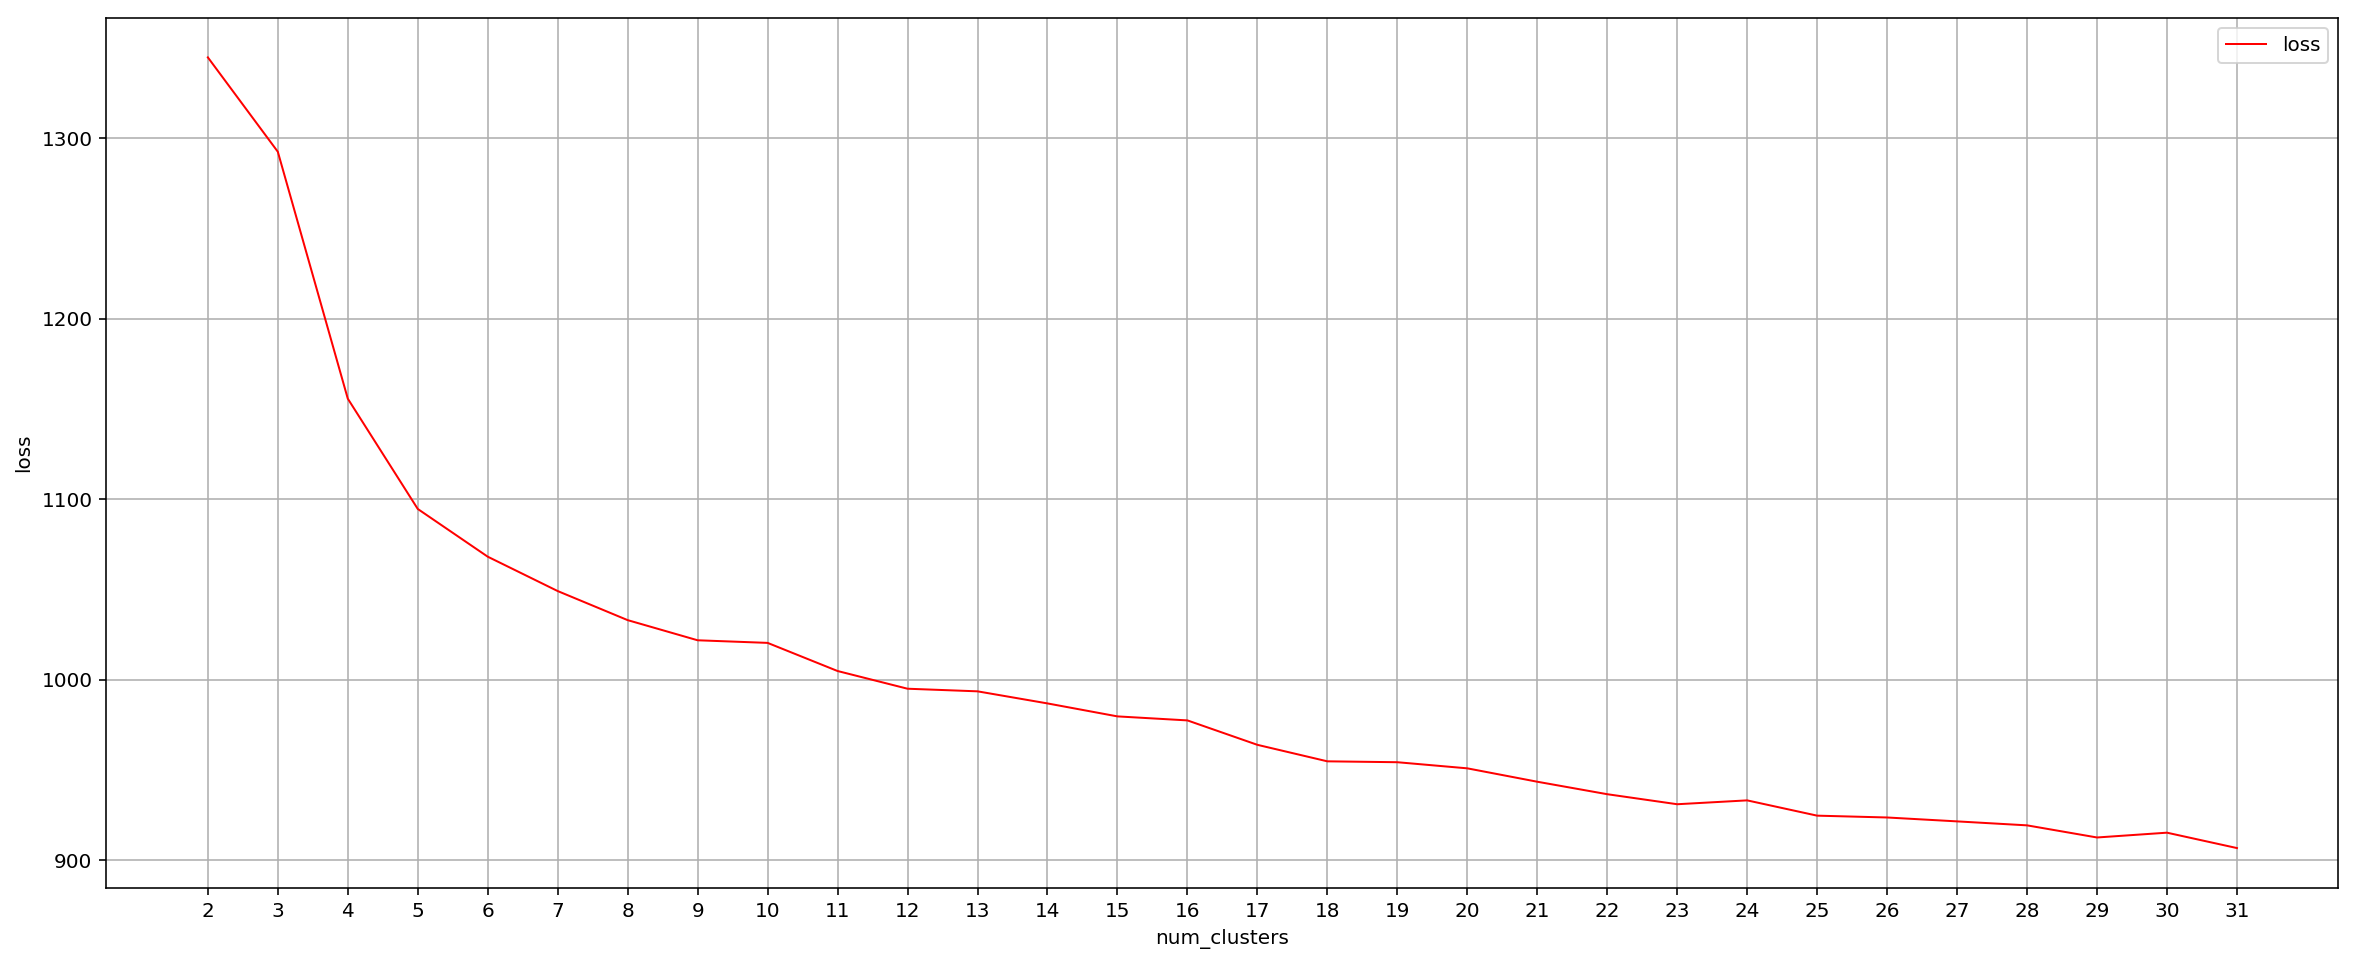

In [38]:
test(sent2vec)

## Train

In [50]:
result = out(sent2vec, 4)

Cluster distribution:
{1: 8849, 3: 1534, 0: 1396, 2: 9494}
0.0570641157349


# Visualizing Document Clusters

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
import pandas as pd

In [47]:
# dist is defined as 1 - the cosine similarity of each document. 
# cosine similarity is measured against the tf-idf matrix and 
# can be used to generate a measure of similarity between each document 
# and the other documents in the corpus.
dist = 1 - cosine_similarity(sent2vec)

## Multidimensional Scaling

In [ ]:
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
# set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

# set up cluster names using a dict
cluster_names = {0: 'Cluster_1', 
                 1: 'Cluster_2', 
                 2: 'Cluster_3',
                 3: 'Cluster_4'}

In [ ]:
# set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# set up cluster names using a dict
cluster_names = {0: 'Cluster_1', 
                 1: 'Cluster_2', 
                 2: 'Cluster_3',
                 3: 'Cluster_4',
                 4: 'Cluster_5'}

In [ ]:
# create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=result[-1])) 

# group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=2000)

# Result

In [81]:
import json
import os

In [95]:
def write_to_file(content, name):
    with open(name, 'a', encoding='utf-8') as f:
        f.write(json.dumps(content, ensure_ascii=False) + '\n')
        f.close()
        
def gen_data(data, label):
    for i in range(len(data)):
        yield {
            'sentence': data[i],
            'cluster': label[i]+1
        }

def prt(cluster):
    for i in range(len(cluster)):
        print('Sentence %d: ' % i)
        print(cluster[i])
        print('————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————')

In [96]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/data/version_2/result_data.json'
for i in gen_data(sentence, result[-1]):
    write_to_file(i, filename)

In [97]:
news = load_data(filename, 'sentence')
cluster = load_data(filename, 'cluster')

# Show

In [101]:
cluster_1 = [news[i] for i in range(len(news)) if cluster[i] == 2]
prt(cluster_1)

Sentence 0: 
KTLINTL(00442)发布公告，于截至2017年3月31日止年度，该公司收益5.48亿港元，同比减少19.9%；母公司拥有人应占亏损915.4万港元，同比减亏32%；毛利率19.5%，同比增长2.7个百分点；每股亏损0.06港元，不派息。公司称，收益减少主要由于俄罗斯销售额减少约9930万港元，此乃由于俄罗斯客户了解卢布贬值及经济前景恶化，且持续受到西方国家制裁的影响，导致俄罗斯家庭对经济状况感到忧虑，致使优质珠宝需求显着受压。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 1: 
中国光大银行(06818)发布公告，已向联交所申请于2017年6月6日后12个月内将20亿美元中期票据计划以仅向专业投资者发行债务的方式上市，该计划的上市预期于2017年6月7日开始生效。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 2: 
嘉东光学(836850)6月5日公告，公司因业务发展需要，为扩大公司产能，拟将办公、生产场所搬迁至合肥市高新区习友路3336号(长宁大道与习友路交口西北角)(原地址为：合肥市高新区繁华大道598号)。新的办公、生产场所为公司自建厂房。公司拟于2017年6月16日开始对办公、生产场所进行搬迁。公司搬迁周期为25天左右，预计于2017年7月10日前完成搬迁，于2017年7月31日前完成生产设备调试工作。
——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

【中新科技：股东联创永溢拟减持不超876万股】中新科技(603996)6月22日晚公告，公司股东联创永溢拟自公告发布之日起三个交易日后的6个月内，减持不超过876万股。注：联创永溢当前持股为882万股，占公司总股本2.94%。（证券时报）
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 550: 
据交易所公告，上海岱美汽车内饰件股份有限公司首次公开发行A股网上中签结果出炉。具体如下：凡参与网上发行申购上海岱美汽车内饰件股份有限公司 A 股股票的投资者持有的申购配号尾数与上述号码相同的，则为中签号码。中签号码共有43,200个，每个中签号码只能认购1,000股上海岱美汽车内饰件股份有限公司A股股票。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 551: 
【福泽集团公布股价暴跌超85%原因：自家董事会主席“清仓”股份】福泽集团(08108，HK)股价于6月16日暴跌85.56%，于下午3点32分短暂停牌，股价较开市下跌1.31港元，收于0.22港元。6月16日约22时，福泽集团对股价暴跌通过公告做出回应，称原因是福泽集团董事会主席李革于公布日期出售所持所有股份所致。（每日经济新闻）
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 552: 
昌兴国际(00803)公布，就公司全资附属富威拟向昌兴物料收购印尼海螺25%股权，于2

————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 1364: 
合矿股份(830856)7月26日发布半年报，2017年上半年公司实现营业收入4181万元，同比上升7.94倍，净利润539万元，去年同期亏损135万元，同比扭亏。相比上年同期，公司营业收入及净利润均实现大幅增长，主要系公司“绿战略”发展规划的有效实施。凭借在技术领域的竞争优势和“绿战略”市场的大力扩张，公司已进入快速成长期，在业内的竞争力也得到了显著提升。资料显示，合矿股份主要从事湿地特种挖掘机、液压挖掘机、液压抓料机等工程机械产品的研发、生产和销售。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 1365: 
根据联交所资料显示，非执董李兆基于本周一(5日)场外增持美丽华酒店(00071)1089万股，每股作价13.5元，总值1.47亿元；同日他亦场内增持美丽华酒店405万股或0.59%，每股作价16.84元，总值6820万元，最新持股量增至47.7%。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 1366: 
天视文化(834548)8月8日发布收购报告书，收购人华侨城文化集团拟通过认购公司定向发行的1600万股获得控股权，认购金额为9600万元。收购完成后，华侨城文化集团将持有天视文化1600万股股票，占发行后总股本的 35.60%，成为天视文化的控股股东

————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 2228: 
美锦能源5日晚间公告，公司预计2017年上半年盈利48,000万元–52,000万元，比上年同期增长389.66% -430.46%。公司表示，业绩同比大幅增长，主要是受市场形势持续向好的影响，公司的主要产品焦炭及煤炭销售价格较上年同期大幅上涨，焦炭的销售数量较上年有所增加。
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 2229: 
【海王生物：上半年净利预增长约100%-150%】海王生物(000078)7月6日晚间公告，预计上半年净利润约2亿元-2.5亿元，比上年同期上升约99.73%-149.66%。主要因为公司原有业务增长带来利润增长，公司近年新收购的业务（含新设立公司）带来利润增长。（证券时报）
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Sentence 2230: 
金利科技19日晚间公告，由于彩量科技100%股权的交易价格的调整，占公司最近一个会计年度经审计的合并财务会计报告期末净资产额的比例未达到50%以上，也未达《上市公司重大资产重组管理办法》中所规定的重大资产重组其他标准，因此公司决定不以重大资产重组方式收购彩量科技。对于公司拟增加的收购标的公司力天无限部分股权事项，在本次重组推进过程中，由于近期国内证券市场环境及监管政策等客观情况发生较大变化，双方未能就交

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [100]:
len(cluster_1)

9494